# Analyse the embeddings

### 1.1 import

In [1]:
import warnings

from matplotlib.pyplot import subplots

%reload_ext autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import json
from IMPACT import utils
from IMPACT import model
from IMPACT import dataset
import torch
import pandas as pd

import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1.2. logger set up

In [4]:
utils.setuplogger(verbose = True, log_name="Embedding_explore")

In [5]:
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


### 1.3. Metric computing

In [5]:
dataset_name = 'postcovid'
algo_name = 'Bivaecf_cornac'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_Iter_fold{i_fold}_seed_{0}.csv', header=None).to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../embs/postcovid_Bivaecf_cornac_Iter_fold0_seed_0.csv'

In [6]:
dataset_name = 'portrait'
layer_n = 2
algo_name = f'DotProduct_{layer_n}_without_init_cont_model'

embs = []
for i_fold in range(5) :
    embs.append(pd.read_csv(f'../embs/{dataset_name}_{algo_name}_fold_{i_fold}_seed_{0}.csv', header=None).to_numpy())

FileNotFoundError: [Errno 2] No such file or directory: '../embs/portrait_DotProduct_2_without_init_cont_model_fold_0_seed_0.csv'

#### 1.3.3. DOA

In [ ]:
reload(utils)
utils.compute_doa(embs, dataset_name, algo_name)

#### 1.3.2. Correlation coeff

In [ ]:
reload(utils)
utils.compute_corr_coeff(embs=embs, dataset_name=dataset_name,fold_nb=5)

#### 1.3.1. RM

In [ ]:
reload(utils)
utils.compute_rm(embs=embs, dataset_name=dataset_name)

### 1.4. Qualitative study
#### 1.4.1. Imports

In [3]:
import pandas as pd

df = pd.read_csv("./data/portrait_hyperparam_study.csv", header=0, sep=",").astype(float)

In [4]:
df = df.rename(columns ={'rmse':'rmse_avg', 'mae':'mae_avg', 'pc-er':'pc-er_avg'})

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib
# Reset RC parameters to the default settings.
plt.rcdefaults()

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
XXL_SIZE = 14

plt.rc('font', size=XXL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

def plot_evolution_with_nb_params(metric, df):
    """
    Plots the evolution of a metric (with std dev),
    plus a secondary axis for the number of parameters.
    """
    # Sort dataframe for consistency
    df = df.sort_values('num_responses')

    ##########################################################
    # First axis (ax1) for your main metric
    ##########################################################

    fig, ax1 = plt.subplots()

    # Extract arrays for the main metric
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot mean +/- std
    line1 = ax1.plot(x, y, label=f"{metric} mean", color='tab:blue')
    ax1.fill_between(
        x, y - std, y + std,
        alpha=0.2, color='tab:blue',
        label=f"{metric} confidence interval ($\pm$ std)"
    )

    # Axis labels and style
    ax1.set_xlabel(r'$|M|$')
    ax1.set_ylabel(metric.upper(), color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # X-axis ticks and limits
    ax1.set_xticks(x)
    ax1.set_xlim(left=4)

    # Y-axis limits to ensure they incorporate mean -/+ std
    y_min = df[metric + '_avg'].min() - df[metric + '_std'].max()
    y_max = (df[metric + '_avg'].max() + df[metric + '_std'].max()
             + 0.1 * (df[metric + '_avg'].max() - df[metric + '_avg'].min()))
    ax1.set_ylim(bottom=y_min, top=y_max)

    # Example vertical line from y_min to the avg at x=12
    selected_x = 12
    selected_y = df[df['num_responses'] == selected_x][metric + '_avg'].values[0]

    # Example horizontal line from x=4 to x=12 at that same selected_y
    ax1.hlines(
        y=selected_y,
        xmin=4,
        xmax=selected_x,
        color='black',
        linestyle='--',
        label='Selected hyperparameter'
    )

    # Make sure the main axes lines are visible
    ax1.set_facecolor('none')
    for spine in ['top', 'right', 'bottom', 'left']:
        ax1.spines[spine].set_visible(True)

    ##########################################################
    # Second axis (ax2) for the number of parameters
    ##########################################################

    ax2 = ax1.twinx()  # shares the same x-axis as ax1

    # Define a function to compute the number of parameters
    def nb_params(d_r:int, M:int):
        dim_n  = 9
        user_n = 1152
        quest_n = 116
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

    # Generate data for the second axis
    x2 = np.arange(5, 26)  # match the domain of x for consistency
    y2 = [nb_params(d_r=6, M=m) for m in x2]  # e.g., d_r=6

    line2 = ax2.plot(
        x2, y2,
        color='tab:green',
        label='Number of IMPACT parameters'
    )

    # Label and style for second axis
    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Formatter to display large numbers as 'xx×10^3'
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e3)}$\\times10^3$"
    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))

    # Set y-limits for the second axis (adjust as needed)
    ax2.set_ylim(bottom=0, top=45000)

    # Example vertical line for the second axis at x=12, from 0 to y2
    x_v = selected_x
    y_v = nb_params(d_r=6, M=x_v)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    # from x=selected_x to the right
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        linestyle='--',
        color='black',
    )

    ##########################################################
    # Combine legends
    ##########################################################

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/" + str(metric) + "_portrait_hyperparam.pdf")
    plt.show()

# Example usage:
# plot_evolution_with_nb_params('exec_time', df[df['d_in']==6].drop_duplicates('num_responses'))


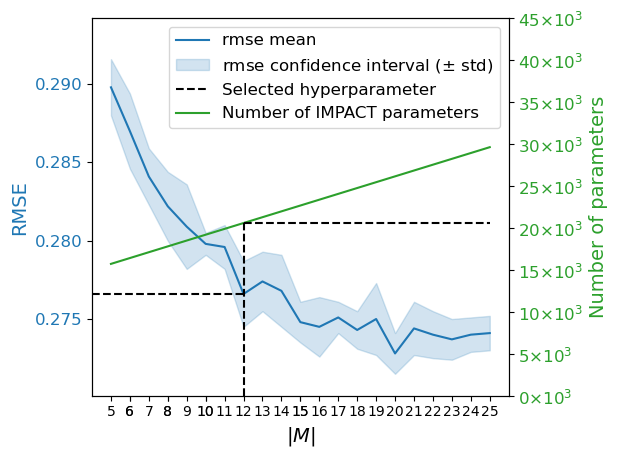

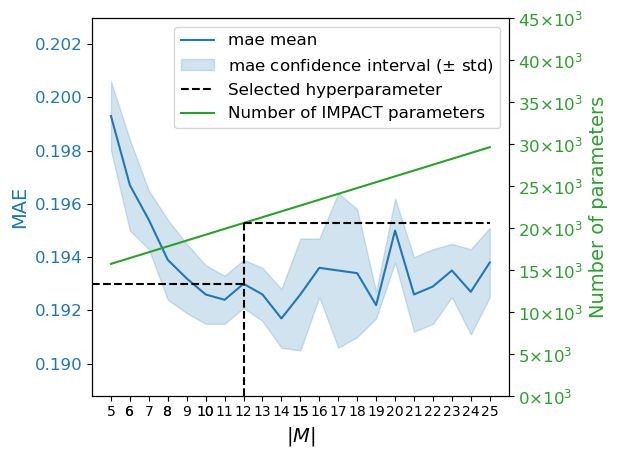

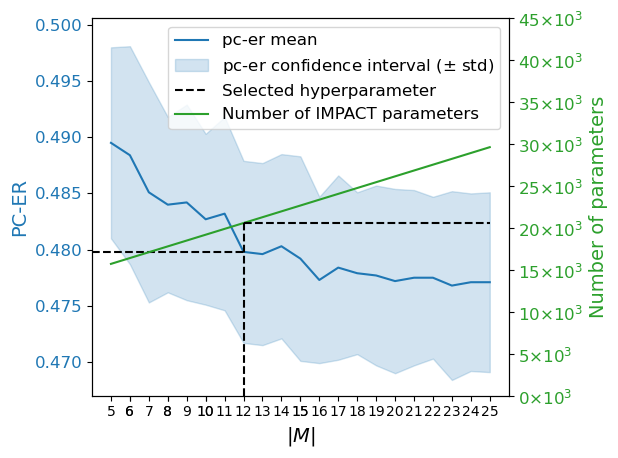

In [39]:
plot_evolution_with_nb_params('rmse',df[df['d_in']==6])
plot_evolution_with_nb_params('mae',df[df['d_in']==6])
plot_evolution_with_nb_params('pc-er',df[df['d_in']==6])

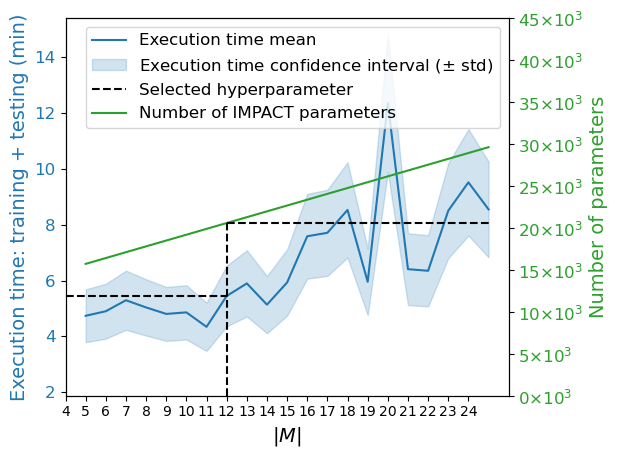

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

plt.rc('font', size=XXL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def plot_evolution_time_with_nb_params(metric, df):
    # Sort dataframe for consistency
    df = df.sort_values('num_responses')

    # Create figure and first axis (for execution times)
    fig, ax1 = plt.subplots()

    # Extract arrays for the first axis
    x   = np.array(df['num_responses'])
    y   = np.array(df[metric + '_avg'] / 60)   # Convert seconds to minutes
    std = np.array(df[metric + '_std'] / 60)   # Convert seconds to minutes

    # Plot mean +/- std for execution time
    line1 = ax1.plot(x, y, label='Execution time mean', color='tab:blue')
    ax1.fill_between(x, y - std, y + std, alpha=0.2, color='tab:blue',
                     label=f"Execution time confidence interval ($\pm$ std)")

    ax1.set_xlabel(r'$|M|$')
    ax1.set_ylabel("Execution time: training + testing (min)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # You can set the x-ticks and x-limits as you wish
    ax1.set_xticks(np.arange(4, 25))
    ax1.set_xlim(left=4)

    # Ensure the lower y-limit makes sense for your data
    y_min = (df[metric + '_avg'].min()/60 - df[metric + '_std'].max()/60)
    ax1.set_ylim(bottom=y_min)

    # Example vertical line (from y_min to the mean at x=12)


    # Example horizontal line (from x=4 to x=12 at the mean for x=12)
    ax1.hlines(
        y=df[df['num_responses'] == 12][metric + '_avg'].values[0] / 60,
        xmin=4,
        xmax=12,
        color='black',
        linestyle='--',
        label='Selected hyperparameter'

    )

    ###########################################################################
    # Create a second axis to plot the number of parameters
    ###########################################################################

    ax2 = ax1.twinx()  # shares the same x-axis with ax1

    def nb_params(d_r:int, M:int) :
        dim_n  = 9
        user_n = 1152
        quest_n= 116
        # Simple example formula (adjust if needed):
        return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

    # Generate data for the second plot
    # Make sure the range matches your x-axis from ax1
    x2 = np.arange(5, 26)
    y2 = [nb_params(d_r=6, M=m) for m in x2]  # Example: d_r=6

    line2 = ax2.plot(x2, y2, color='tab:green', label='Number of IMPACT parameters')

    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # You can define a formatter to make large numbers more readable
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e3)}$\\times10^3$"

    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=0, top=45000)

    # Example vertical line for the second axis at x=12
    x_v = 12
    y_v = nb_params(d_r=6, M=x_v)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        color='black',
        linestyle='--',
    )

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/" + str(metric) + "_portrait_hyperparam.pdf")
    plt.show()

# Usage example (assuming you have loaded your DataFrame `df`):
plot_evolution_time_with_nb_params('exec_time', df[df['d_in']==6].drop_duplicates('num_responses'))


In [41]:
import pandas as pd

df = pd.read_csv("./data/movielens_hyperparam_study.csv", header=0, sep=",").astype(float)

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def nb_params(d_r: int, M: int):
    dim_n  = 11
    user_n = 4231
    quest_n= 2421
    # Simple example formula:
    return d_r * dim_n * dim_n + (M + 2) * d_r * quest_n + user_n * dim_n

# Example data for second axis
Y = [nb_params(x,5) for x in range(2,22)]

def plot_evolution(metric, df):
    # Sort by d_in just to be consistent
    df = df.sort_values('d_in')

    fig, ax = plt.subplots()

    # Primary axis data
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg'])
    std = np.array(df[metric + '_std'])

    # Plot on primary axis
    ax.plot(x, y, label=f"{metric} mean", color='tab:blue', zorder=3)
    ax.fill_between(x, y - std, y + std, alpha=0.2,
                    label=f"{metric} ± std", color='tab:blue', zorder=2)

    ax.set_xlabel(r"$d_r$")
    ax.set_ylabel(metric.upper(), color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xticks(np.arange(2, 22))

    min_val = y.min() - 0.1*(y.max() - y.min())
    max_val = (y + std).max() + 0.1*(y.max() - y.min())
    ax.set_ylim(bottom=min_val, top=max_val)
    ax.set_xlim(left=1.5)

    # Example lines on primary axis
    ax.vlines(x=10, ymin=min_val, ymax=df.loc[df['d_in'] == 10, metric + '_avg'].item(),
              linestyle='--', color='black', zorder=1)
    ax.hlines(y=df.loc[df['d_in'] == 10, metric + '_avg'].item(),
              xmin=0, xmax=10, color='black', linestyle='--',
              label='Selected hyperparameter', zorder=1)
    ax.vlines(x=11, ymin=min_val, ymax=max_val, color='red', linestyle='-',
              label="Users' embedding dim $|C|$", zorder=1)

    # -----------------------
    # Create twin axis
    ax2 = ax.twinx()
    ax2.patch.set_visible(False)
    # (Optional) If you want a separate background color for ax2, leave patch visible:
    # Otherwise: ax2.patch.set_visible(False)  # to remove background

    # Plot data on twin axis
    x2 = np.arange(2, 22)
    line2 = ax2.plot(x2, Y, color='tab:green', label='Number of IMPACT parameters', zorder=-1)
    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # Format large numbers
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e4)}$\\times10^4$"
    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(50000, 450000)

    # Example lines on ax2
    x_v = 10
    y_v = nb_params(d_r=x_v, M=5)
    ax2.vlines(x=x_v, ymin=0, ymax=y_v,
               linestyle='--', color='black', zorder=-1)
    ax2.hlines(y=y_v, xmin=x_v, xmax=25,
               color='black', linestyle='--', zorder=-1)

    # -----------------------
    # Combine legends
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

    # Make a single legend on the primary axis
    leg = ax.legend(lines1 + lines2, labels1 + labels2,
                    loc='best', framealpha=0.7)

    # Force a draw so Matplotlib lines up everything
    plt.draw()

    # Re-insert the legend as the last artist on ax so it’s definitively on top
    ax.add_artist(leg)
    # Give it a high zorder
    leg.set_zorder(9999)

    fig.tight_layout()
    plt.savefig(f"../../figs/{metric}_movielens_hyperparam.pdf")
    plt.show()


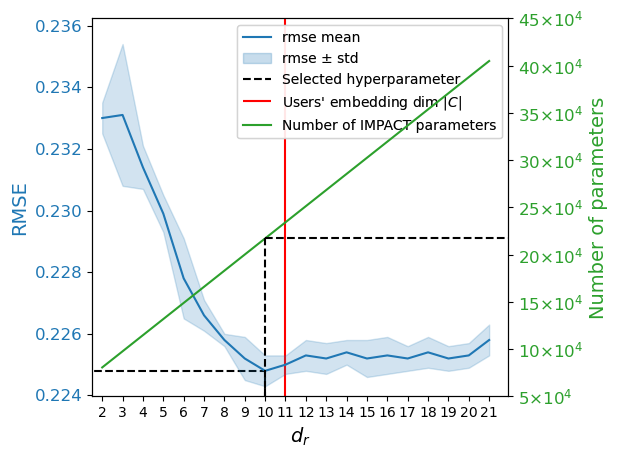

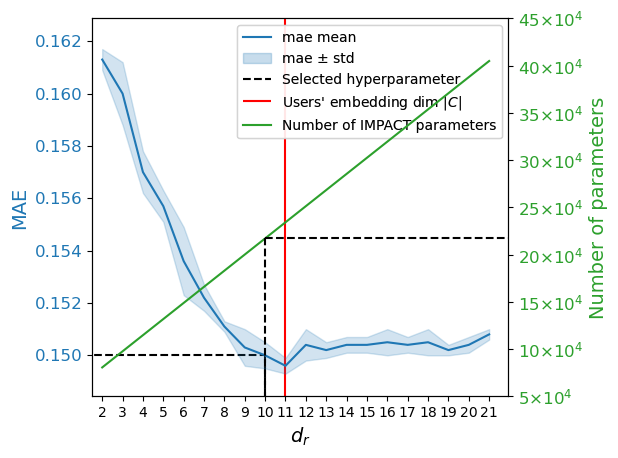

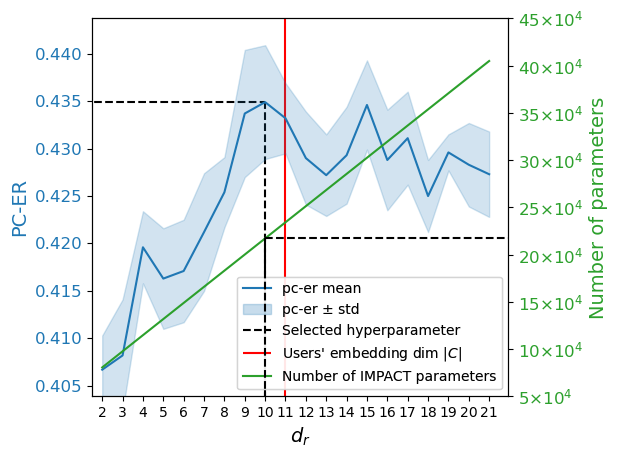

In [111]:
plot_evolution('rmse',df)
plot_evolution('mae',df)
plot_evolution('pc-er',df)

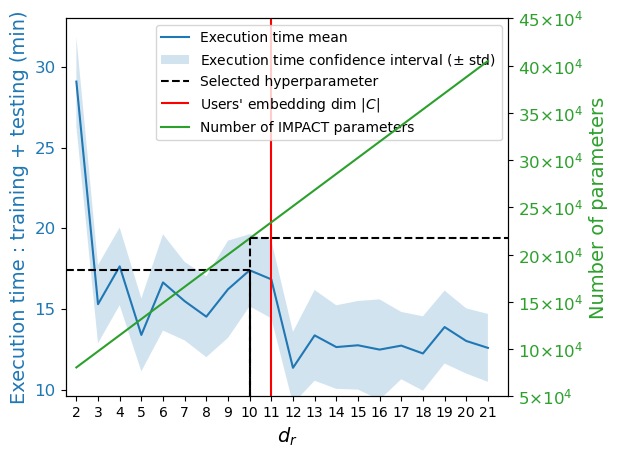

In [109]:
def plot_evolution_time(metric,df) :

    df = df.sort_values('d_in')
    fig, ax = plt.subplots()

    # Extract arrays
    x   = np.array(df['d_in'])
    y   = np.array(df[metric + '_avg']/60)
    std = np.array(df[metric + '_std']/60)

    # Plot mean +/- std
    ax.plot(x, y, label='Execution time mean')
    ax.fill_between(x, y - std, y + std, alpha=0.2, label="Execution time confidence interval ($\pm$ std)")


    ax.set_ylabel("Execution time : training + testing (min)", color='tab:blue')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax.set_xlabel(r'$d_r$')
    ax.set_xticks(np.arange(2,22))

    # If you want the x-axis to start at 0
    ax.set_xlim(left=1.5)

    # If you want the y-axis to start at 0 so the vertical line can begin at y=0
    ax.set_ylim(bottom=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60))

    # Example vertical line from y=0 to y=0.234 at x=10
    ax.vlines(
        x=10,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=df[df['d_in']==10][metric + '_avg']/60,
        color='black',
        linestyle='--',
    )

    # Example horizontal line from x=0 to x=10 at y=0.2248
    ax.hlines(
        y=df[df['d_in']==10][metric + '_avg']/60,
        xmin=0,
        xmax=10,
        color='black',
        linestyle='--',
        label = 'Selected hyperparameter'
    )

    ax.vlines(
        x=11,
        ymin=df[metric + '_avg'].min()/60-0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),       # start from y=0
        ymax=np.max(df[metric + '_avg'] +df[metric + '_std'])+0.1*(df[metric + '_avg'].max()/60 - df[metric + '_avg'].min()/60),
        color='red',
        label = f'Users\' embedding dim $|C|$'
    )


    ax2 = ax.twinx()  # shares the same x-axis with ax

    # Generate data for the second plot
    # Make sure the range matches your x-axis from ax
    x2 = np.arange(2, 22)
    line2 = ax2.plot(x2, Y, color='tab:green', label='Number of IMPACT parameters')

    ax2.set_ylabel("Number of parameters", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    # You can define a formatter to make large numbers more readable
    def tick_formatter(x_val, pos):
        return f"{int(x_val/1e4)}$\\times10^4$"

    ax2.yaxis.set_major_formatter(FuncFormatter(tick_formatter))
    ax2.set_ylim(bottom=50000, top=450000)

    # Example vertical line for the second axis at x=12
    x_v = 10
    y_v = nb_params(d_r=x_v, M=5)
    ax2.vlines(
        x=x_v,
        ymin=0,
        ymax=y_v,
        linestyle='--',
        color='black',
    )

    # Example horizontal line for the second axis
    ax2.hlines(
        y=y_v,
        xmin=x_v,
        xmax=25,
        color='black',
        linestyle='--',
    )

    # Combine legends from both axes
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')

    # Save the figure
    fig.tight_layout()
    plt.savefig("../../figs/"+str(metric) + "_movielens_hyperparam.pdf")

plot_evolution_time('exec_time',df)